In [77]:
import numpy as np 
import matplotlib.pyplot as plt 

def fft1d(inp,dim): 
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(inp,axes=dim),axis=dim),axes=dim)

def ifft1d(inp,dim):
    return np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(inp,axes=dim),axis=dim),axes=dim)

N = 256 
X,Y = np.meshgrid(np.arange(-N/2,N/2), np.arange(-N/2,N/2), indexing='xy')

# Make Numerical Phantom

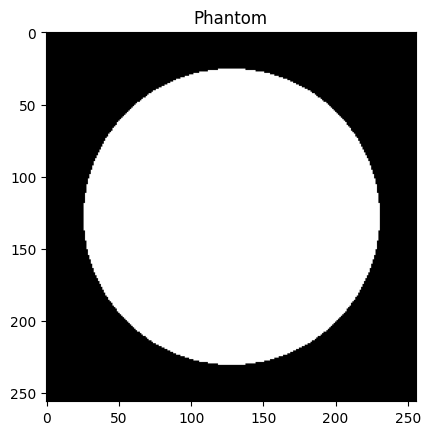

In [78]:

# simple circle phantom 
R = np.sqrt(X**2 + Y**2) 
phantom = np.zeros((N,N), dtype=np.float32) 
phantom[R < N/2.5] = 1.0

mask = np.zeros_like(phantom) 
mask[np.abs(phantom) > 0.0] = 1.0 

plt.figure()
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.show() 


# Make Coil Sensitivity Profiles 

Signal intensity decays rapidly the further away from each RF coil. Simulate this decay in two dimensions with the following. Four coils, one at each corner of the image, are simulated here. 

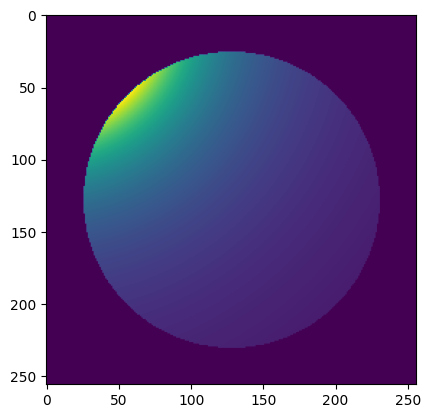

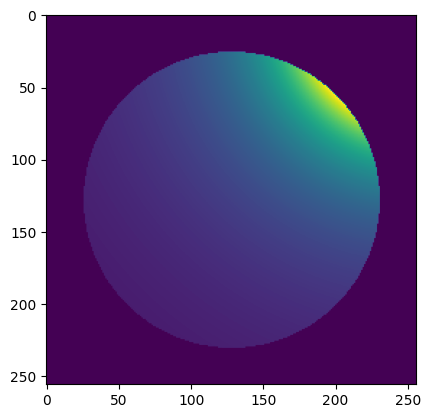

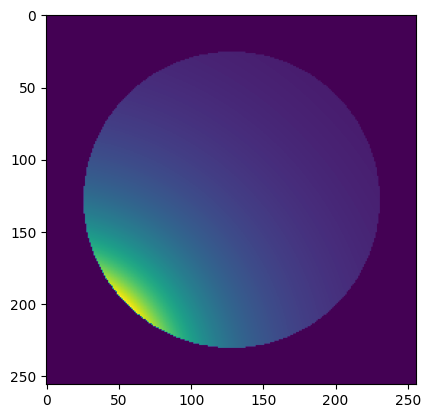

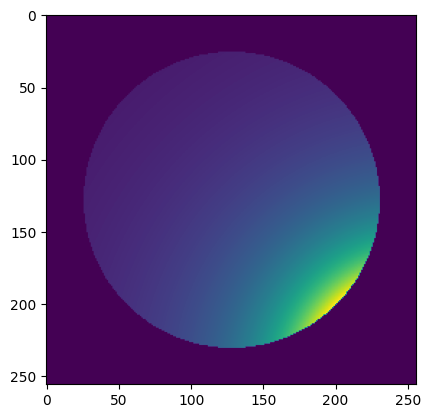

In [79]:
coilLocationRow = [-N/2,-N/2,N/2-1,N/2-2]
coilLocationCol = [-N/2,N/2-1,-N/2,N/2-1]
ncoils = len(coilLocationRow) 

S = np.ones((N,N,ncoils),dtype=np.float32)

for c in range(ncoils):

    R = np.sqrt((X-coilLocationCol[c])**2 + (Y-coilLocationRow[c])**2)
    R[R == 0.0] = 1.0 # avoid division by zero 
    S[:,:,c] = 1.0 / (R**2)

    plt.figure() 
    plt.imshow(S[:,:,c] * mask)
    plt.show() 

# Smasked = S * mask[:,:,None]
# Smax = np.max(np.abs(Smasked))
# S[np.abs(S) > Smax] = 0.01




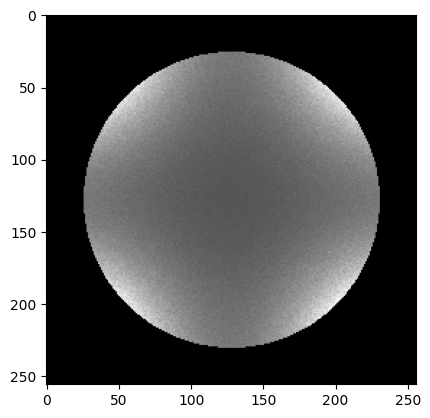

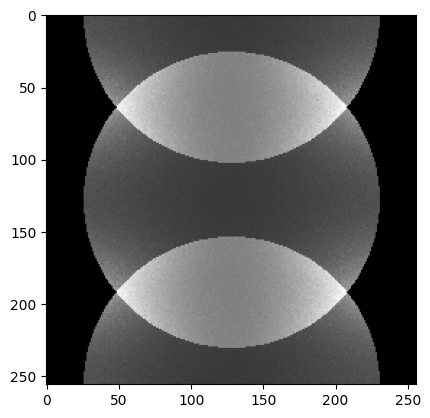

In [80]:

# make noisy images for each 
noiseStandardDeviation = 0.05
coilImages = (phantom[...,None] + noiseStandardDeviation*np.random.randn(N,N,ncoils) + 1j*noiseStandardDeviation*np.random.randn(N,N,ncoils)) * S * mask[:,:,None]

# simulate k-space with forward FFT 
ksp = fft1d(fft1d(coilImages,0),1)

# get 2-fold undersampled k-space 
uksp = np.zeros_like(ksp)
uksp[0::2,:,:] = ksp[0::2,:,:]

# reconstruct images 
img = ifft1d(ifft1d(ksp,0),1)
uimg = ifft1d(ifft1d(uksp,0),1)

# combine coils 
rss_img = np.abs(np.sqrt(np.sum(img*np.conj(img),axis=-1)))
rss_uimg = np.abs(np.sqrt(np.sum(uimg*np.conj(uimg),axis=-1)))

plt.figure()
plt.imshow(rss_img,cmap='gray')
plt.show()

plt.figure()
plt.imshow(rss_uimg,cmap='gray')
plt.show()


# Perform Under

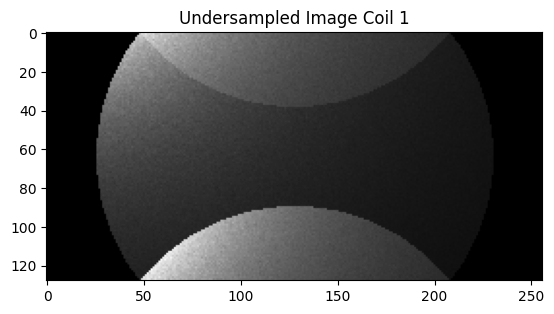

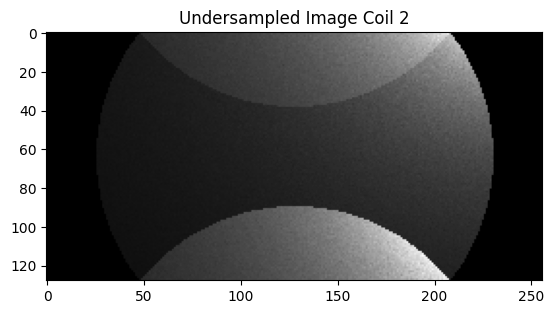

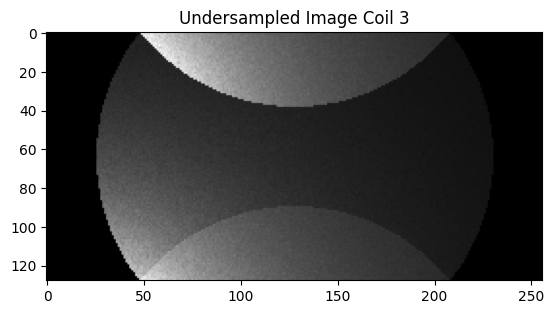

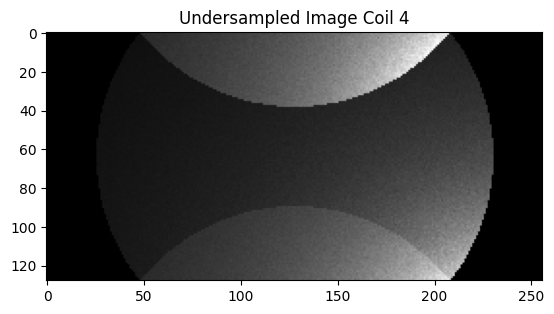

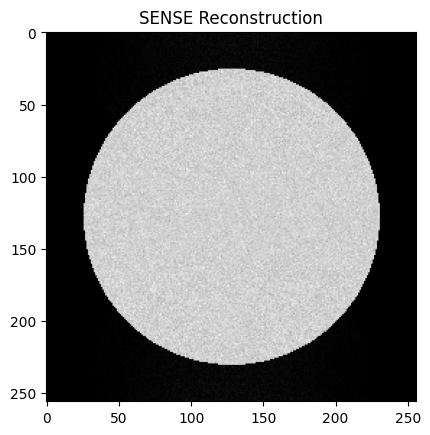

In [81]:

# get acquired data only (uksp above was zero-filled at non-acquired locations)
data = ksp[0::2,:,:]

# get undersampled coil images 
uimg = ifft1d(ifft1d(data,0),1)

for c in range(ncoils):
    plt.figure()
    plt.imshow(np.abs(uimg[:,:,c]),cmap='gray')
    plt.title('Undersampled Image Coil %i'%(c+1))
    plt.show()

# now reconstruct a full image from the multi-coil aliased images 
recon = np.zeros((N,N),dtype=np.complex64)

for row in range(uimg.shape[0]):
    for col in range(uimg.shape[1]):

        row1 = int(row + N/4) 
        row2 = int(row1 + N/2) 
        if row2 >= N: 
            row2 = row2 - N

        # build matrices for equation Y = A * B
        Y = np.zeros((ncoils,), dtype=np.complex64)
        A = np.zeros((ncoils,2), dtype=np.complex64)
        for coil in range(ncoils):

            Y[coil] = uimg[row,col,coil]
            A[coil,0] = S[row1,col,coil]
            A[coil,1] = S[row2,col,coil]

        Ah = np.conj(A.T)
        B = np.linalg.inv(Ah@A) @ (Ah@Y)
        recon[row1,col] = B[0]
        recon[row2,col] = B[1]



plt.figure()
plt.imshow(np.abs(recon),cmap='gray')
plt.title('SENSE Reconstruction')
plt.show()
